Purpose of this notebook is to use LORA (aka Low Rank Adaptation method) and finetune

In [1]:
# !python -m pip install -q datasets peft evaluate

In [2]:
# !python -m pip uninstall -y pyarrow datasets ibis-framework

In [3]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [4]:
# !python -m pip show pyarrow datasets

In [5]:
# !python -m pip install pyarrow>=15.0.0 datasets peft evaluate

In [6]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (AutoTokenizer,
                         AutoConfig,
                         AutoModelForSequenceClassification,
                         DataCollatorWithPadding,
                         TrainingArguments,
                         Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/home/jupyter/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'mps'
print(device)

cuda


#### Base Model (mobileBERT)

In [8]:
model_checkpoint = 'google/mobilebert-uncased'
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


# generate classification model from model chckpoints
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=8,
    id2label=id2label,
    label2id=label2id
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

#### Load dataset

In [10]:
df = pd.read_csv("data/marco_train_v2.csv")
print(len(df))
print(df['target'].value_counts())
df.head(10)

148123
target
information_intent    114381
yelp_intent            18178
weather_intent         13196
navigation_intent       1350
purchase_intent          519
travel_intent            322
translation_intent       162
unknown                   15
Name: count, dtype: int64


,sequence,target
0,medication used to treat cold sores,yelp_intent
1,what is netflix canceling,information_intent
2,definition of ethnographic,information_intent
3,what are housing rates,information_intent
4,transmission fluid flush how often,information_intent
5,what is trade,information_intent
6,what does severance package mean,information_intent
7,how to purify water in the wilderness,information_intent
8,what are the criteria for,information_intent
9,what is property tax in san diego california,information_intent


count    148123.000000
mean         28.956239
std          10.173896
min           6.000000
10%          17.000000
20%          21.000000
25%          22.000000
30%          23.000000
40%          26.000000
50%          28.000000
60%          30.000000
70%          33.000000
75%          34.000000
80%          36.000000
90%          41.000000
95%          45.000000
98%          53.000000
99%          59.000000
99.5%        68.000000
99.8%        84.000000
99.9%        97.000000
max         193.000000
Name: sequence, dtype: float64


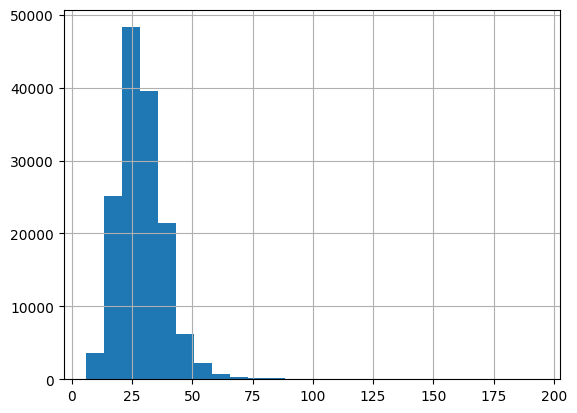

In [11]:
print(df['sequence'].apply(len).describe(percentiles=[.1, .2, .25, .3, .4, .5, .6, .7, .75, .8, .9, .95, .98, .99, .995, .998, .999]))
df['sequence'].apply(len).hist(bins=25);

In [12]:
pd.set_option('display.max_colwidth', 100)
df.loc[df['sequence'].apply(lambda text: len(text) > 64)]

,sequence,target
54,who is the master chief petty officer of the coast guard reserve force,information_intent
71,what are appropriate means for leaving evidence of presence? (select,information_intent
98,what type of ideology has gained popularity throughout latin america?,information_intent
147,"if a president is accused of breaking the twenty-second amendment, that means the president is t...",information_intent
173,​a legal maximum on the price at which a good can be sold is called a price,information_intent
...,...,...
127601,which president pushed through congress the civil rights act of 1964 brainly,information_intent
127656,which of the following basic allowance for housing rate is for soldiers living in barracks,information_intent
127936,"for a typical person who leads a sedentary lifestyle, a typical maximum oxygen intake level woul...",information_intent
128054,which bonds are created during the formation of the primary structure of a protein?,information_intent


In [ ]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

token_lengths = []
for sequence in df['sequence'].values:
    tokens = tokenizer(sequence, truncation=False)['input_ids']  # Get tokenized input IDs
    token_lengths.append(len(tokens))

# Create a DataFrame for analysis
temp_df = pd.DataFrame({'sequence': df['sequence'].values, 'token_length': token_lengths})

# Display token lengths
print(temp_df)

# Optional: Analyze token lengths for deciding the best max_length
print(f"Max token length: {temp_df['token_length'].max()}")
print(f"Average token length: {temp_df['token_length'].mean()}")
print(f"90th percentile token length: {temp_df['token_length'].quantile(0.9)}")
print(f"95th percentile token length: {temp_df['token_length'].quantile(0.95)}")
print(f"98th percentile token length: {temp_df['token_length'].quantile(0.98)}")
print(f"99th percentile token length: {temp_df['token_length'].quantile(0.99)}")
print(f"99.5th percentile token length: {temp_df['token_length'].quantile(0.995)}")
print(f"99.9th percentile token length: {temp_df['token_length'].quantile(0.999)}")

del temp_df

In [14]:
# Select only a sample from the actual data

sampling_percentages = {
    'information_intent': 0.2,  # 20% sampling for information_intent
    'yelp_intent': 1.0,          # 100% sampling for yelp_intent
    'weather_intent': 1.0,       # 100% sampling for weather_intent
    'navigation_intent': 1.0,    # 100% sampling for navigation_intent
    'purchase_intent': 1.0,      # 100% sampling for purchase_intent
    'translation_intent': 1.0,   # 100% sampling for translation_intent
    'travel_intent': 1.0,        # 100% sampling for travel_intent
    'unknown': 1.0               # 100% sampling for unknown
}

# Sample from each target group based on the defined percentages
sampled_df = df.groupby('target', group_keys=False).apply(
    lambda x: x.sample(frac=sampling_percentages.get(x.name, 1.0))
).reset_index(drop=True)

sampled_df['label'] = sampled_df['target'].map(label2id)
# sampled_df = sampled_df.rename(columns={'target': 'label'})

print(sampled_df['label'].value_counts())
print(f"Size of sampled_df = {len(sampled_df)}")
sampled_df.head()

label
0    22876
1    18178
5    13196
2     1350
4      519
3      322
6      162
7       15
Name: count, dtype: int64
Size of sampled_df = 56618


/var/tmp/ipykernel_6462/3487378760.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('target', group_keys=False).apply(


,sequence,target,label
0,marijuana stocks price,information_intent,0
1,where is lugano switzerland,information_intent,0
2,how to read an architect scale,information_intent,0
3,what is tuition at michigan state university,information_intent,0
4,how to monitor gpu temperature,information_intent,0


In [15]:
# Step 1: Split the DataFrame into train and validation sets
train_df, val_df = train_test_split(sampled_df, test_size=0.05, random_state=42, stratify=sampled_df['label'])

# Step 2: Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)

# Step 3: Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

# Step 4: Verify the structure of DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 53787
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label'],
        num_rows: 2831
    })
})


In [16]:
train_df['label'].value_counts()

label
0    21732
1    17269
5    12536
2     1283
4      493
3      306
6      154
7       14
Name: count, dtype: int64

In [17]:
val_df['label'].value_counts()

label
0    1144
1     909
5     660
2      67
4      26
3      16
6       8
7       1
Name: count, dtype: int64

#### Preprocess data

In [18]:


# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

# tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["sequence"]

    # tokenize and truncate text
    tokenizer.truncation_side = "right"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,  # Pad the sequences to the longest in the batch
        max_length=64
    )
    return tokenized_inputs

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)
# tokenized_dataset = tokenized_dataset.map(fix_labels)
tokenized_dataset

Map: 100%|██████████| 2831/2831 [00:00<00:00, 25212.06 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 53787
    })
    validation: Dataset({
        features: ['sequence', 'target', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2831
    })
})

#### Evaluation Metrics

In [20]:
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=1)
    # Combine metrics
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    # Calculate metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [21]:
### Evaluate untrained model

text_list = [
    'floor repair cost',
    'denture fix',
    'who is the us president',
    'italian food',
    'sandwiches in seattle',
    'seattle weather',
    'weather seattle',
    'boston wether',
    'Boston wether',
    'weather boston',
    'weather Boston',
    'Weather Boston',
    'weathr boston',
    'seattle weathr',
]

sample_labels = [
    label2id["yelp_intent"],
    label2id["yelp_intent"],
    label2id["information_intent"],
    label2id["yelp_intent"],
    label2id["yelp_intent"]
]

print("Untrained model predictions:")
print("----------------------------")
predictions = []
logits_list = []
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt")
    logits = model(inputs).logits
    prediction = torch.argmax(logits, dim=1).item()
    predictions.append(prediction)
    print(text + " -> " + id2label[prediction])

Untrained model predictions:
----------------------------
floor repair cost -> information_intent
denture fix -> information_intent
who is the us president -> information_intent
italian food -> information_intent
sandwiches in seattle -> information_intent
seattle weather -> information_intent
weather seattle -> information_intent
boston wether -> information_intent
Boston wether -> information_intent
weather boston -> information_intent
weather Boston -> information_intent
Weather Boston -> information_intent
weathr boston -> information_intent
seattle weathr -> information_intent


#### Model finetuning with LoRA

In [23]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                         r=4, # intrinsic rank of trainable weight matrix
                         lora_alpha=32, # similar to learning_rate
                         lora_dropout=0.01, # probability of dropout nodes
                         target_modules=['attention.self.query']) # LoRA is applied to query layer


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 28,680 || all params: 24,614,672 || trainable%: 0.1165


In [24]:
# for name, module in model.named_modules():
#     print(name)

#### Define hyper parameters and training arguments

In [25]:
lr = 1e-3
batch_size = 16
num_epochs = 10

# training args
training_args = TrainingArguments(
    # output_dir=model_checkpoint + "-lora-intent-classification-v3",
    output_dir="mobilebert-uncased" + "-lora-intent-classification-v3",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
trainer = Trainer(
    model=model, 
    args=training_args, # Hyperparamaters
    train_dataset=tokenized_dataset["train"], # training data
    eval_dataset=tokenized_dataset["validation"], # validation data
    tokenizer=tokenizer, # tokenizer
    data_collator=data_collator, # dynamic sequence padding
    compute_metrics=compute_metrics,  # model perfomance evaluation metric
)


In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,206.533300,0.685373,0.937831,0.937266,0.937831,0.936803
2,1014.233100,1.700965,0.942423,0.942275,0.942423,0.941208
3,964.142300,6.571901,0.948428,0.948305,0.948428,0.947598
4,767.387600,21.453617,0.953373,0.953291,0.953373,0.952601
5,518.152000,0.149336,0.961851,0.961294,0.961851,0.961495
6,306.871800,2.405443,0.961498,0.960648,0.961498,0.960416
7,352.161000,14.204342,0.961851,0.961684,0.961851,0.961635
8,41.528300,2.416231,0.970329,0.970017,0.970329,0.969768
9,36.199600,6.597254,0.968562,0.968283,0.968562,0.968328
10,4.333000,0.107496,0.972448,0.972365,0.972448,0.972356


/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter/new_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jupyter/ne

TrainOutput(global_step=33620, training_loss=2304.9549859532, metrics={'train_runtime': 3502.7715, 'train_samples_per_second': 153.556, 'train_steps_per_second': 9.598, 'total_flos': 2644552736296416.0, 'train_loss': 2304.9549859532, 'epoch': 10.0})

In [37]:
# trainer.model

In [30]:
trainer.model.eval()
with torch.no_grad():
    for text in text_list:
        inputs = tokenizer.encode(text, return_tensors="pt").to(device)
        logits = trainer.model(inputs).logits
        prediction = torch.argmax(logits, dim=1).item()
        print(text + " -> " + id2label[prediction])

floor repair cost -> yelp_intent
denture fix -> yelp_intent
who is the us president -> information_intent
italian food -> yelp_intent
sandwiches in seattle -> yelp_intent
seattle weather -> weather_intent
weather seattle -> weather_intent
boston wether -> weather_intent
Boston wether -> weather_intent
weather boston -> weather_intent
weather Boston -> weather_intent
Weather Boston -> weather_intent
weathr boston -> weather_intent
seattle weathr -> weather_intent


In [31]:
!ls -lh mobilebert-uncased-lora-intent-classification-v3/checkpoint-33620

total 1.4M
-rw-r--r-- 1 jupyter jupyter 5.0K Oct 10 12:36 README.md
-rw-r--r-- 1 jupyter jupyter  679 Oct 10 12:36 adapter_config.json
-rw-r--r-- 1 jupyter jupyter 119K Oct 10 12:36 adapter_model.safetensors
-rw-r--r-- 1 jupyter jupyter 266K Oct 10 12:36 optimizer.pt
-rw-r--r-- 1 jupyter jupyter  14K Oct 10 12:36 rng_state.pth
-rw-r--r-- 1 jupyter jupyter 1.1K Oct 10 12:36 scheduler.pt
-rw-r--r-- 1 jupyter jupyter  125 Oct 10 12:36 special_tokens_map.json
-rw-r--r-- 1 jupyter jupyter 695K Oct 10 12:36 tokenizer.json
-rw-r--r-- 1 jupyter jupyter 1.3K Oct 10 12:36 tokenizer_config.json
-rw-r--r-- 1 jupyter jupyter  16K Oct 10 12:36 trainer_state.json
-rw-r--r-- 1 jupyter jupyter 5.2K Oct 10 12:36 training_args.bin
-rw-r--r-- 1 jupyter jupyter 227K Oct 10 12:36 vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Load the LoRA model from checkpoint after training

In [32]:
id2label = {0: 'information_intent',
            1: 'yelp_intent',
            2: 'navigation_intent',
            3: 'travel_intent',
            4: 'purchase_intent',
            5: 'weather_intent',
            6: 'translation_intent',
            7: 'unknown'}
label2id = {label:id for id,label in id2label.items()}


output_dir = "mobilebert-uncased-lora-intent-classification-v3/checkpoint-33620"

# Load the tokenizer (from the output directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir, return_tensors="pt", padding="max_length", truncation=True, max_length=64)

# Load the base model from the original checkpoint (base pre-trained model)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Load the LoRA configuration and model
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Save the combined model to a directory
save_directory = "tmp/mobilebert_lora_combined_model/"
lora_model.save_pretrained(save_directory)  # Save base model + LoRA weights

# Now the `lora_model` contains both the base model and the LoRA weights.
lora_model.eval()

# Example inference
inputs = tokenizer(["looking for home cleaning "], return_tensors="pt")
outputs = lora_model(**inputs)
logits = outputs.logits
print(logits)


prediction = torch.argmax(logits, dim=1).item()
print(prediction, id2label[prediction])
probabilities = torch.softmax(logits, dim=1)
rounded_probabilities = torch.round(probabilities)
print(rounded_probabilities)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[37367.0977, 37333.8594, 37001.4570, 29453.9238, 35999.8438, 37165.7148,
         34981.0977, 17471.5176]], grad_fn=<AddmmBackward0>)
0 information_intent
tensor([[1., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<RoundBackward0>)


In [35]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel, PeftConfig

# Step 1: Load the base model (DistilBERT)
base_model = AutoModelForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=8, id2label=id2label, label2id=label2id)

# Step 2: Load the LoRA adapter weights
output_dir = "mobilebert-uncased-lora-intent-classification-v3/checkpoint-33620"
peft_config = PeftConfig.from_pretrained(output_dir)
lora_model = PeftModel.from_pretrained(base_model, output_dir)

# Step 3: Merge LoRA weights into the base model
# After this, the model will have both base and LoRA weights applied
merged_model = lora_model.merge_and_unload()

# Step 4: Save the full model (base model + LoRA weights)
save_directory = "tmp/mobilebert_lora_combined_model/"
merged_model.save_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(output_dir)  # Load the tokenizer
tokenizer.save_pretrained(save_directory)  # Save the tokenizer


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('tmp/mobilebert_lora_combined_model/tokenizer_config.json',
 'tmp/mobilebert_lora_combined_model/special_tokens_map.json',
 'tmp/mobilebert_lora_combined_model/vocab.txt',
 'tmp/mobilebert_lora_combined_model/added_tokens.json',
 'tmp/mobilebert_lora_combined_model/tokenizer.json')

In [36]:
# !huggingface-cli whoami

In [ ]:
merged_model_dir = "tmp/mobilebert_lora_combined_model"
merged_repo_id = "Mozilla/mobilebert-uncased-finetuned-LoRA-intent-classifier"  

merged_model.push_to_hub(merged_repo_id)
tokenizer.push_to_hub(merged_repo_id)